# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
#from osgeo import ogr, gdal, osr
import fiona
from rasterstats import zonal_stats
import rasterio
import rasterio.fill
#from geojson import Feature, Point, FeatureCollection
import h3 as h3

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [3]:
# import ipywidgets as widgets
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

#import seaborn as sns

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
os.path.abspath(os.curdir)

'c:\\Users\\rheredia\\OneDrive - Imperial College London\\UKPACT\\EDeMOS_Kenya'

In [6]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs/"

In [7]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY
EPSG:4326


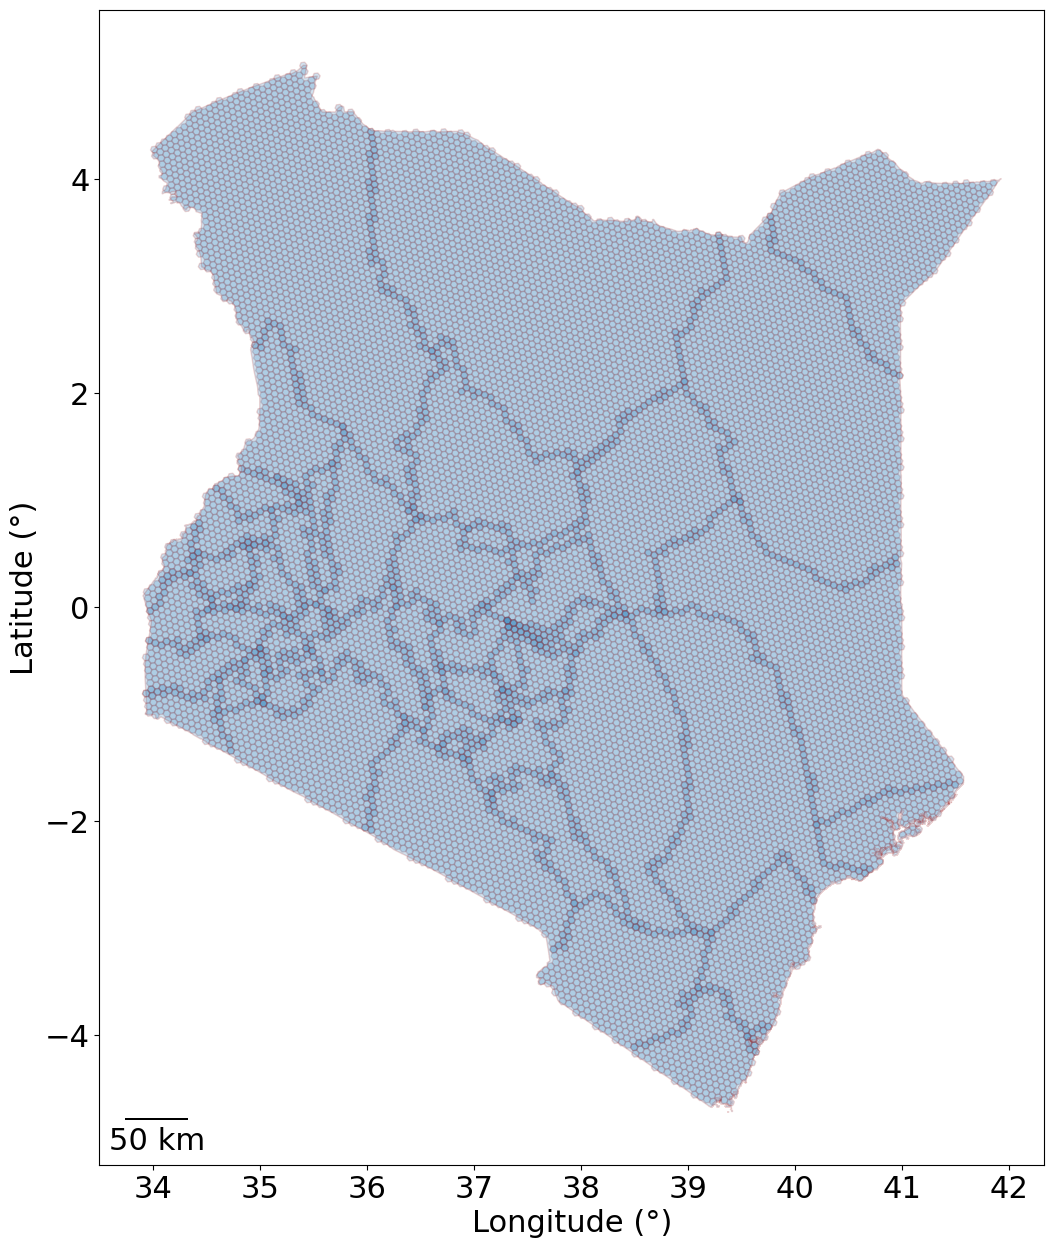

<Figure size 640x480 with 0 Axes>

In [8]:
%run BaseGridHex.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [9]:
#grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [10]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

In [11]:
## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "gadm41_KEN.gpkg"      
region_col_name = "NAME_1"   ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"
layer_region_name = "ADM_ADM_1"
layer_admin_name = "ADM_ADM_0"
if area == "COUNTRY":
    admin_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)

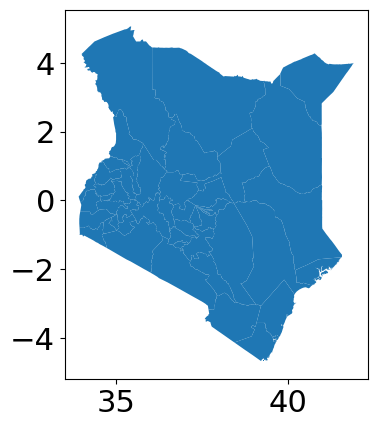

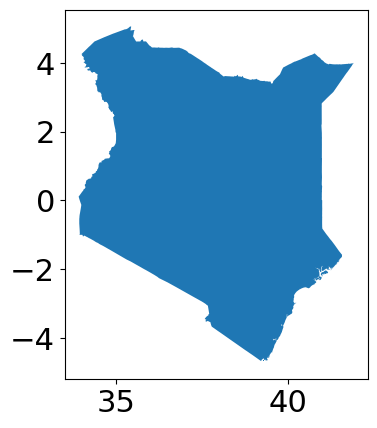

In [12]:
region_gdf.plot(), admin_gdf.plot()
plt.show()

In [13]:
# transmission lines  

#https://energydata.info/dataset/kenya-kenya-electricity-network

# 220KV

lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Transmission lines 220kV/220kV.shp")

if lines_gdf.crs != crs_WGS84:
    lines_gdf = lines_gdf.to_crs(crs_WGS84)

lines_gdf = gpd.clip(lines_gdf, admin_gdf)

In [14]:
#132kV

lines_132 = gpd.read_file(ROOT_DIR + "/Grid/Transmission lines 132kV/132kV.shp")

if lines_132.crs != crs_WGS84:
    lines_132 = lines_132.to_crs(crs_WGS84)

lines_132 = gpd.clip(lines_132, admin_gdf)

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year

**Commercial**  = Number of employee X average en. con. kWh/employee

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

In [15]:
currentdir = os.path.abspath(os.getcwd())
os.path.basename(currentdir)

'EDeMOS_Kenya'

2025-05-28 15:49:05.653478
2025-05-28 15:50:06.668326
2025-05-28 15:51:21.308015
2025-05-28 15:52:04.947293
2025-05-28 15:52:59.875601
2025-05-28 15:53:56.258321
2025-05-28 15:55:12.821327
2025-05-28 15:55:16.667778
-1.434999942779541
1.267071315220424
Residential electricity consumption UN stats 3554.98 GWh
services electricity consumption UN STATS: 1,495 GWh


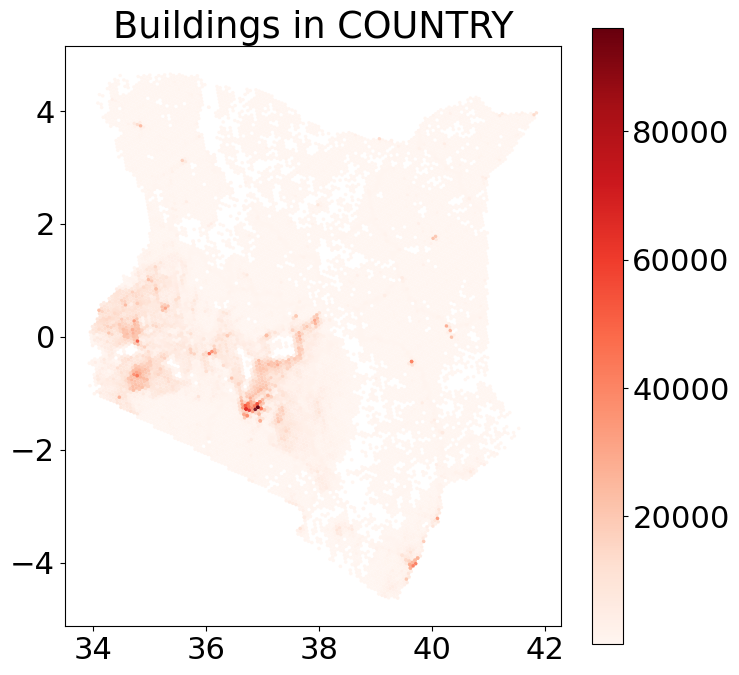

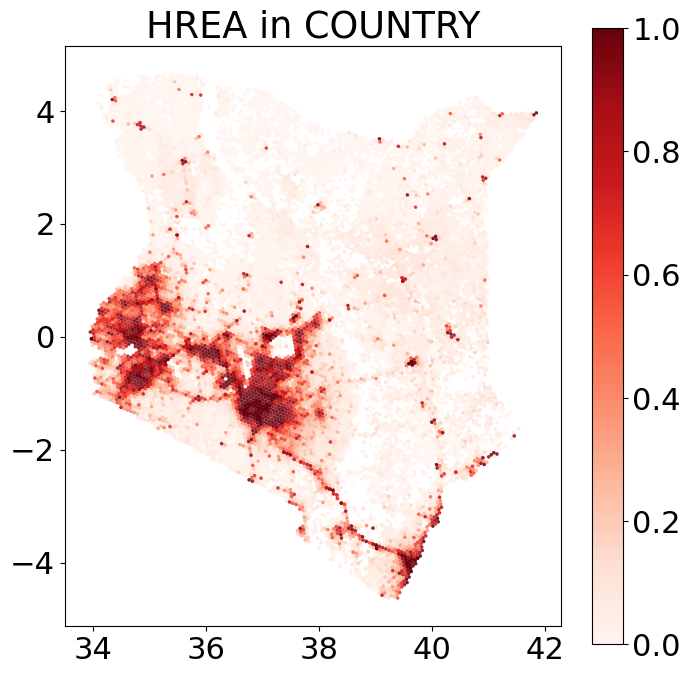

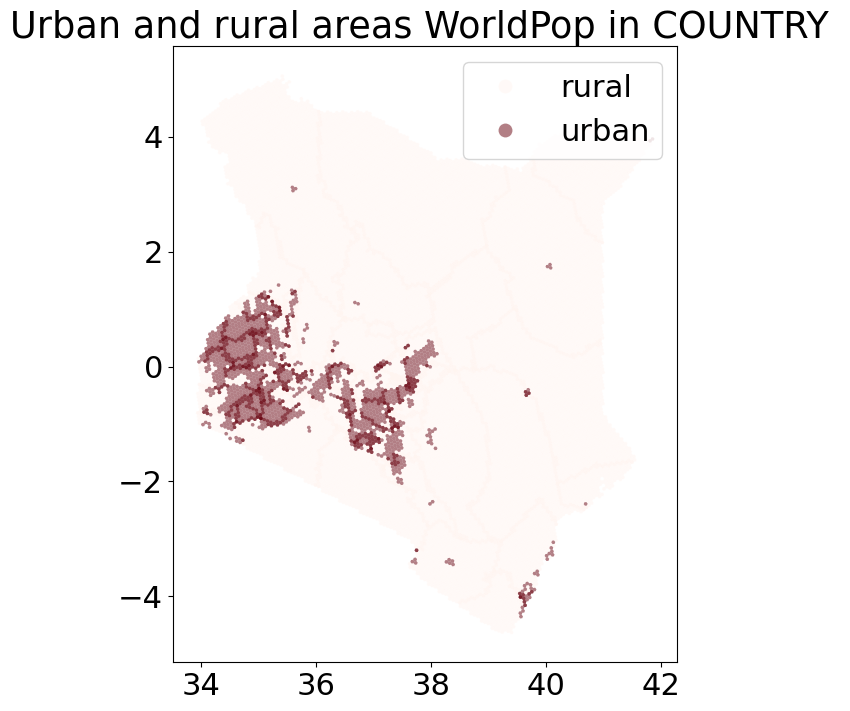

Status_electrified
nonelec    13764
elec        3533
Name: count, dtype: int64
Total population: 46,370,425
Total population: 46,370,425
Total population with access: 22,190,309
Pop access rate : 48%
Pop access rate urban: 63%
Pop access rate rural: 41%


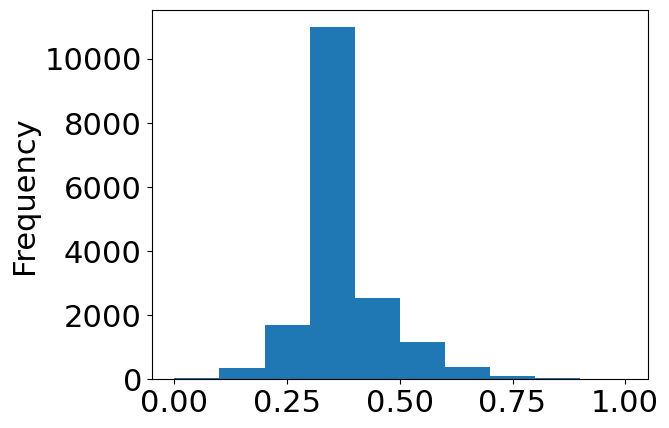

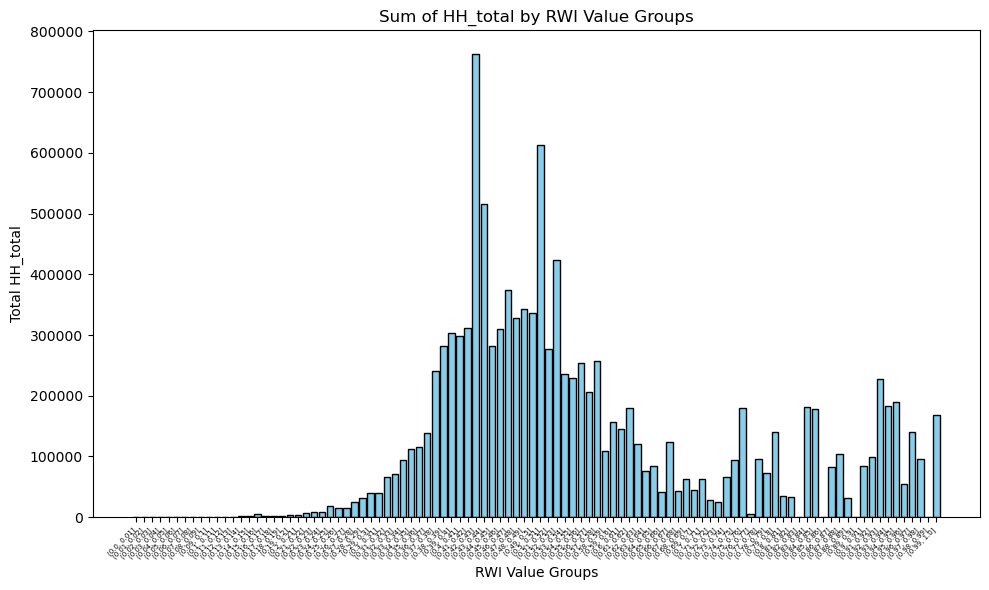

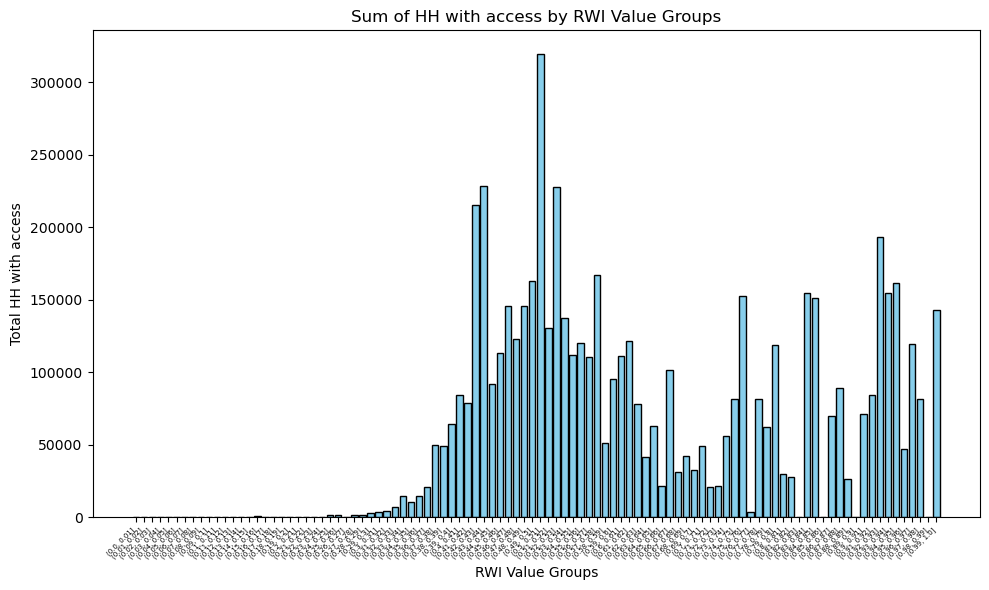

[14.33018636]


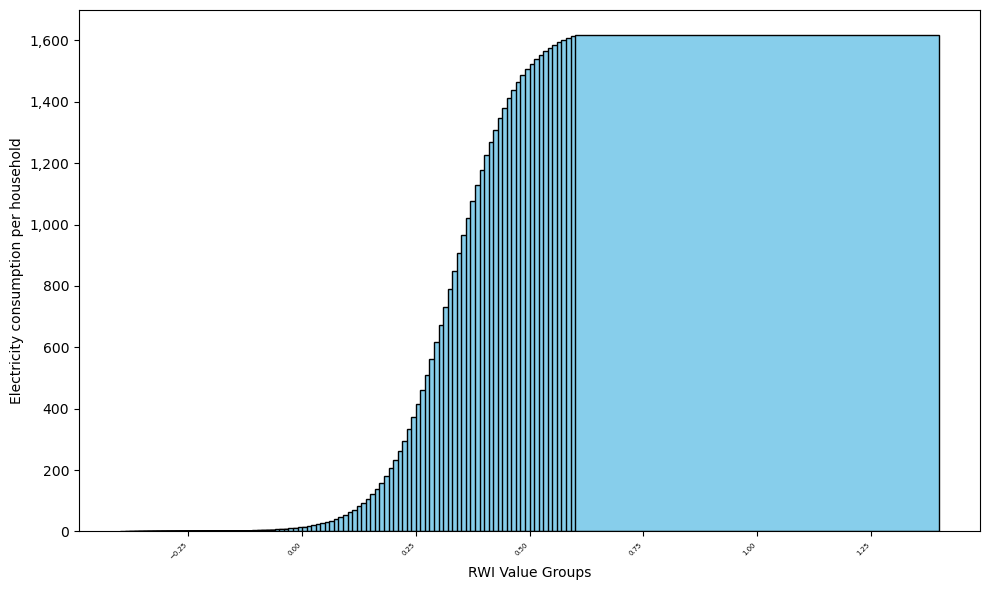

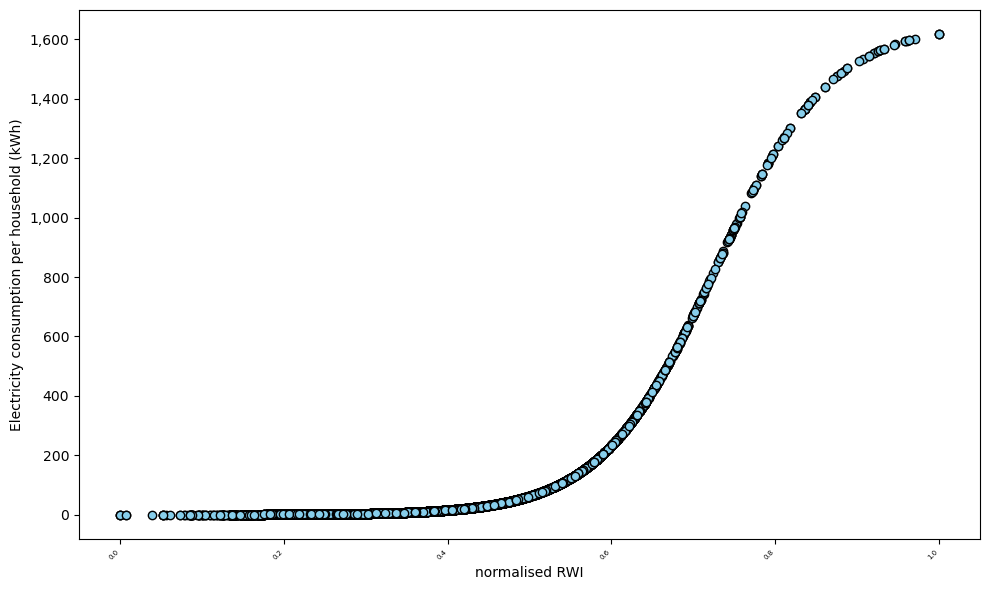

urban total = 3,597 GWh/year
urban average per houshold = 1,218 kWh/year
urban min = 0 kWh/year max = 1,312 kWh/year
Created rwi_vs_energy_use_urban.png


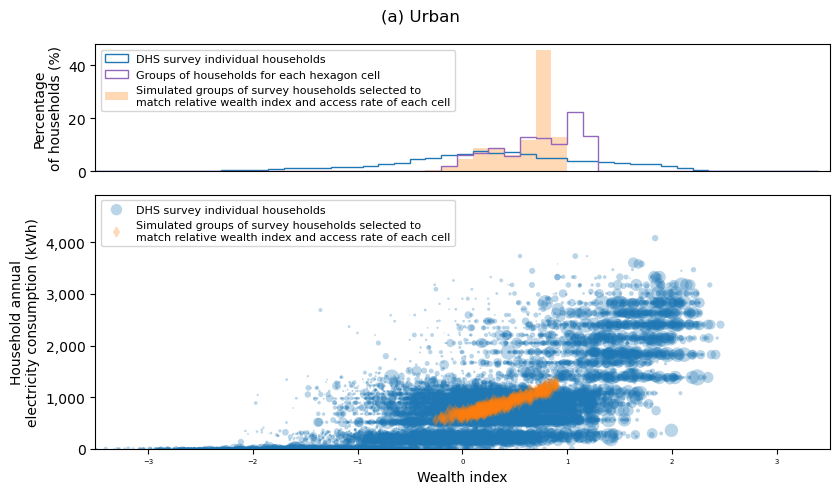

rural total = 1,938 GWh/year
rural average per houshold = 635 kWh/year
rural min = 0 kWh/year max = 746 kWh/year
Created rwi_vs_energy_use_rural.png


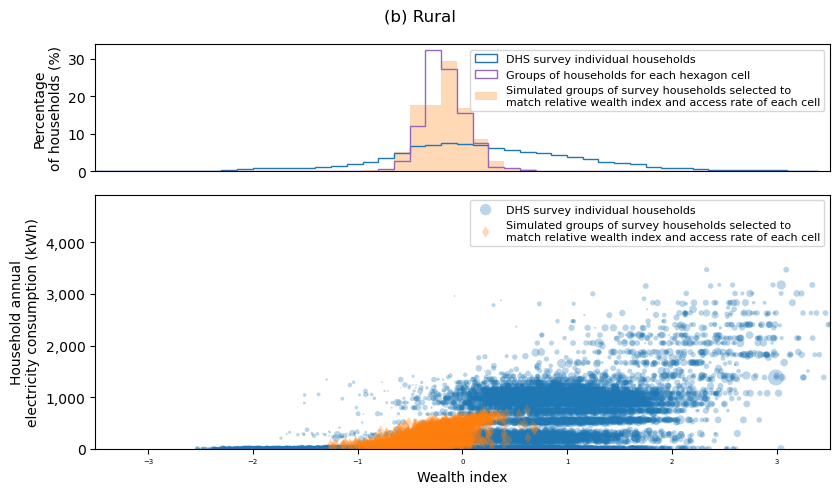

             national  urban  rural
tiers_meth1                        
0                0.50   0.37   0.58
1                0.16   0.01   0.26
2                0.13   0.10   0.14
3                0.08   0.18   0.01
4                0.13   0.34   0.00
5                0.00   0.00   0.00
             national  urban  rural
tiers_meth2                        
0                0.49   0.37   0.57
1                0.00   0.00   0.00
2                0.10   0.00   0.16
3                0.40   0.60   0.26
4                0.01   0.03   0.00
5                0.00   0.00   0.00
Number of lines with similar values: 13905
Mean difference: 0.3824940741168989
Median difference: 0.0
Mode difference: 0   0.00
Name: Difference, dtype: float64
Index(['h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index', 'index_righ',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean', 'GDP_PPP', 'geometry',
       'locWorldPop', 'location', 'Statu

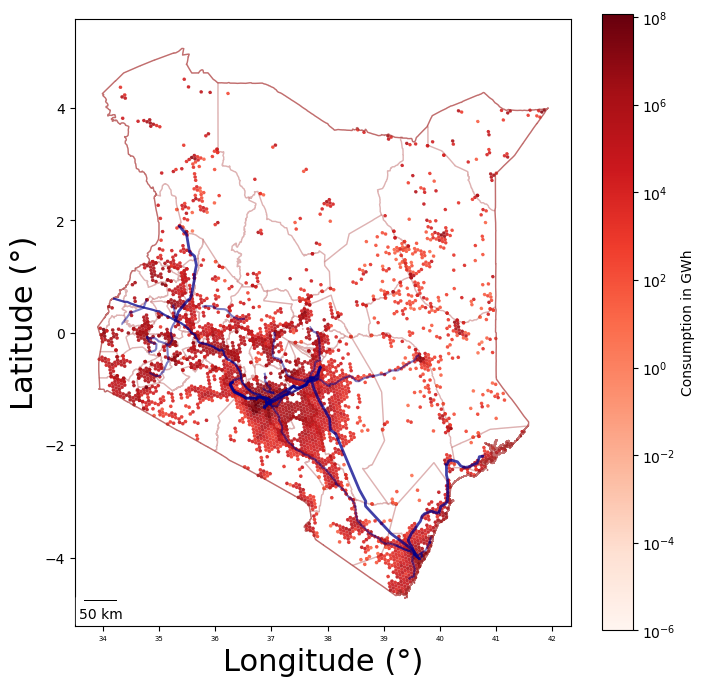

17,455,049 services buildings
total services buildings with access: 11,633,206
129 kWh per building
total GDP (k$): 11,133,313
134 kWh per unit of GDP (k$)
Total number of women: 5,950,081
Total number of men: 5,696,143
nb of working women 1,678,286
nb of total employee 4,862,299
nb of total employee with access 3,935,981
380 kWh per employee


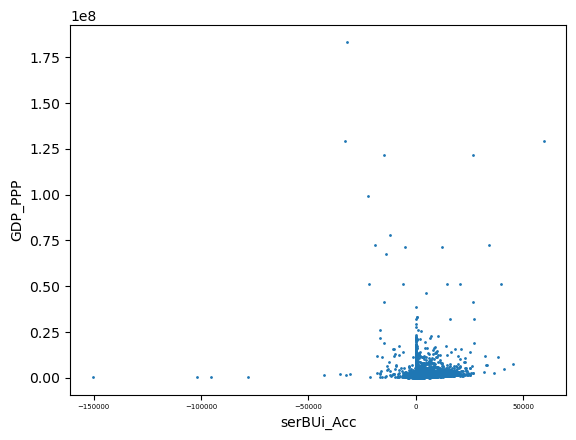

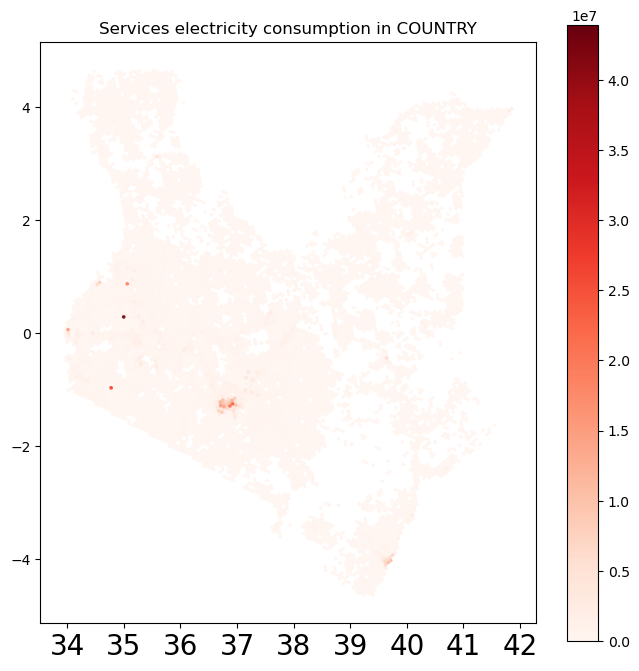

Services electricity consumption assessed after scaling:
Baringo 20.6 GWh
Bomet 21.6 GWh
Bungoma 46.6 GWh
Busia 25.1 GWh
Elgeyo-Marakwet 11.1 GWh
Embu 20.9 GWh
Garissa 16.9 GWh
Homa Bay 33.8 GWh
Isiolo 6.5 GWh
Kajiado 46.4 GWh
Kakamega 52.6 GWh
Kericho 23.9 GWh
Kiambu 109.5 GWh
Kilifi 49.5 GWh
Kirinyaga 20.9 GWh
Kisii 36.0 GWh
Kisumu 41.8 GWh
Kitui 31.5 GWh
Kwale 18.9 GWh
Laikipia 14.1 GWh
Lamu 4.2 GWh
Machakos 48.6 GWh
Makueni 27.5 GWh
Mandera 7.3 GWh
Marsabit 0.0 GWh
Meru 43.1 GWh
Migori 27.1 GWh
Mombasa 60.8 GWh
Murang'a 30.6 GWh
Nairobi 241.7 GWh
Nakuru 72.0 GWh
Nandi 24.5 GWh
Narok 33.3 GWh
Nyamira 0.0 GWh
Nyandarua 16.8 GWh
Nyeri 28.5 GWh
Samburu 6.6 GWh
Siaya 27.9 GWh
Taita Taveta 10.8 GWh
Tana River 4.6 GWh
Tharaka-Nithi 11.0 GWh
Trans Nzoia 30.7 GWh
Turkana 18.7 GWh
Uasin Gishu 49.5 GWh
Vihiga 0.0 GWh
Wajir 11.8 GWh
West Pokot 9.5 GWh
NAME_1
Baringo            20.63
Bomet              21.57
Bungoma            46.61
Busia              25.05
Elgeyo-Marakwet    11.08
Embu        

In [16]:
%run Residential/building_demand.ipynb

In [17]:
total_residentialenergy_assessed = grid['ResEnergy_kWh_meth2'].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 4,249 GWh


In [18]:
#%run Industry/IndustryDemand.ipynb
#print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

In [19]:
# Concatenate results
out_path = ROOT_DIR + "/Outputs/"
gridBui = gpd.read_file(out_path + "ser_energy_map.geojson") # contains services and residential data
#gridInd = gpd.read_file(out_path + "ind_energy_map.geojson")

grid = gridBui.copy()
#grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
grid.head(4)

h3_index    n0     n1     n2     n3     n4     n5  index  \
0  867a6632fffffff  8198  13989   9269   8097  11139   3372      0   
1  867a4d90fffffff  5822   9564   4408  14147  12089  10039      1   
2  867a5046fffffff  9573   3424  14044   6724  11162   2483      2   
3  867a75b8fffffff  5919   7969   8125   2041   4445   4631      3   

   index_righ      NAME_1  ...  nb_women  nb_men  nb_women_working  \
0          39  Tana River  ...      1.89    1.85              0.13   
1          37       Siaya  ...    134.92  115.02             58.24   
2          45       Wajir  ...     14.30   15.78              1.17   
3          39  Tana River  ...      0.57    0.56              0.04   

   nb_men_working  total_employee  total_employee_withaccess  SEn_kWh_Emp  \
0            0.51            0.64                       0.00       244.74   
1           85.90          144.14                       0.00     54757.93   
2            4.14            5.31                       0.00      2017.99   
3            0.15            0.19                       0.00        73.42   

   SEn_kWh_weighted SEn_kWh_final  \
0               NaN           NaN   
1          54757.93      45239.86   
2           2017.99       1667.22   
3               NaN           NaN   

                                            geometry  
0  POLYGON ((39.00381 -2.64185, 38.96917 -2.64697...  
1  POLYGON ((34.41977 -0.00746, 34.38467 -0.01226...  
2  POLYGON ((40.08479 2.34074, 40.05112 2.33638, ...  
3  POLYGON ((39.72292 -1.92155, 39.68855 -1.92658...  

[4 rows x 75 columns]

In [20]:
# Units
#grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
#grid['IndEnergy_kWh'] = grid['IndEnergy_GWh'] * 10**6
#total_ind = grid["IndEnergy_GWh"].sum()
#print(f"Industry: {total_ind:,.0f}", "GWh")
grid['REnS_kWh'] = grid['ResEnergy_kWh_meth2_scaled']
grid['REnS_GWh'] = grid['REnS_kWh'] / 10**6
total_res = grid["REnS_GWh"].sum()
print(f"Residential: {total_res:,.0f}", "GWh")
grid['SEn_GWh'] = grid['SEn_kWh_final'] / 10**6
grid['SEn_kWh'] = grid['SEn_GWh'] * 10**6
total_ser = grid["SEn_GWh"].sum()
print(f"Services: {total_ser:,.0f}", "GWh")

Residential: 3,555 GWh
Services: 1,495 GWh


In [21]:
grid["TotalDem_GWh"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                                ])), axis=1) #sum in GWh
grid["TotalDem_kWh"]= grid['TotalDem_GWh'] * 10**6
total = grid["TotalDem_GWh"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

total electricity consumption: 5,050 GWh


In [22]:
grid.head(3)

h3_index    n0     n1     n2     n3     n4     n5  index  \
0  867a6632fffffff  8198  13989   9269   8097  11139   3372      0   
1  867a4d90fffffff  5822   9564   4408  14147  12089  10039      1   
2  867a5046fffffff  9573   3424  14044   6724  11162   2483      2   

   index_righ      NAME_1  ...  SEn_kWh_Emp  SEn_kWh_weighted  SEn_kWh_final  \
0          39  Tana River  ...       244.74               NaN            NaN   
1          37       Siaya  ...     54757.93          54757.93       45239.86   
2          45       Wajir  ...      2017.99           2017.99        1667.22   

                                            geometry  REnS_kWh  REnS_GWh  \
0  POLYGON ((39.00381 -2.64185, 38.96917 -2.64697...      0.00      0.00   
1  POLYGON ((34.41977 -0.00746, 34.38467 -0.01226...      0.00      0.00   
2  POLYGON ((40.08479 2.34074, 40.05112 2.33638, ...      0.00      0.00   

   SEn_GWh  SEn_kWh TotalDem_GWh TotalDem_kWh  
0      NaN      NaN         0.00         0.00  
1     0.05 45239.86         0.05     45239.86  
2     0.00  1667.22         0.00      1667.22  

[3 rows x 81 columns]

In [23]:
#Grouped results
res_SEn = grid[['NAME_1','location', 'ResEnergy_kWh_meth2_scaled', 'SEn_kWh_final','TotalDem_kWh']].copy()
res_SEn_grouped = res_SEn.groupby(['NAME_1', 'location']).sum().reset_index()

print(res_SEn_grouped)
res_SEn_grouped.to_csv(out_path + "\\" + "res_SEn_grouped.csv")

        NAME_1 location  ResEnergy_kWh_meth2_scaled  SEn_kWh_final  \
0      Baringo    rural                  4767220.10    16689987.31   
1      Baringo    urban                  2102333.70     3944860.74   
2        Bomet    rural                 35688206.11    19936605.47   
3        Bomet    urban                   148958.14     1631046.83   
4      Bungoma    rural                 30188525.49    36303561.93   
..         ...      ...                         ...            ...   
86      Vihiga    urban                  6707906.88           0.00   
87       Wajir    rural                  3888881.54     5902731.60   
88       Wajir    urban                 15287391.83     5852291.41   
89  West Pokot    rural                  1834457.00     7934700.80   
90  West Pokot    urban                   836165.13     1534194.79   

    TotalDem_kWh  
0    21457207.41  
1     6047194.44  
2    55624811.58  
3     1780004.97  
4    66492087.42  
..           ...  
86    6707906.88  
87    9

### Export result

In [24]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [25]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + 'total_demand_grid.geojson', driver="GeoJSON")
grid.to_file(out_path + f'total_demand.geojson', driver='GeoJSON', index=False)  

## Print maps for quick assessment

In [26]:
plt.rcParams.update({'font.size': 22})

### Total demand map

In [27]:
# # Plot the demand map with use of the full scale
# # Create the axis first
# fig, ax = plt.subplots(figsize=(10, 15))

# # Plot data
# grid.sort_values('TotalDem_GWh', ascending=True).plot(
#     ax=ax, column='TotalDem_GWh', cmap="Reds", legend=True, alpha=0.5)

# ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# # Save plot as figure 
# plt.savefig(out_path +'total_elec_demand_map.png', bbox_inches='tight')

In [28]:
# # Plot the demand map with a threshold value
# # Create the axis first
# # fig, ax = plt.subplots(figsize=(25, 15))
# fig, ax = plt.subplots(figsize=(15, 10))

# # Set the threshold
# # threshold = np.percentile(npgrid['TotalDem'], 90)
# threshold = 0.1 * grid['TotalDemGWh'].max()

# # Plot data
# grid.sort_values('TotalDem_GWh', ascending=True).plot(
#     ax=ax, column='TotalDem_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# # Save plot as figure 
# plt.savefig(out_path +'total_demand_elec_map_threshold.png', bbox_inches='tight')

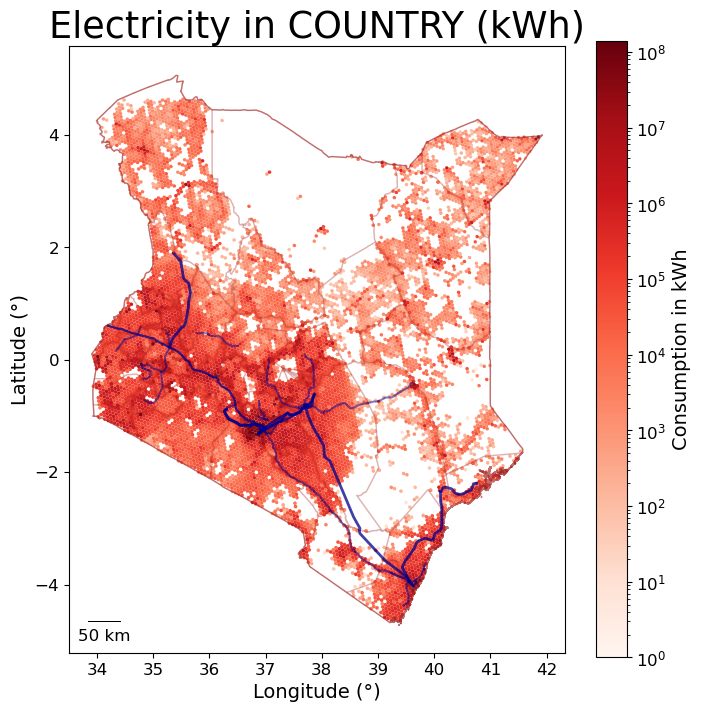

In [44]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlabel('Longitude (°)', fontsize=14)
ax.set_ylabel('Latitude (°)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)


# Plot data
grid.sort_values('TotalDem_kWh', ascending=True).plot(ax=ax,
                column='TotalDem_kWh', cmap="Reds", legend=True,
                 alpha=1, norm=colors.LogNorm(vmin = 1, vmax=grid['TotalDem_kWh'].max()))

#legend
legend = fig.axes[1] 
legend.tick_params(labelsize=12)
legend.set_ylabel("Consumption in kWh", fontsize=14)  # Add a label to the colorbar

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)

lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None,
    font_properties={"size": 12})

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'total_demand_elec_log.png', bbox_inches='tight')

In [43]:
print(lines_gdf.crs)
print(grid.crs)
print(admin_gdf.crs)
print(region_gdf.crs)

EPSG:4326
+init=epsg:4326 +type=crs
EPSG:4326
EPSG:4326


### Residential map

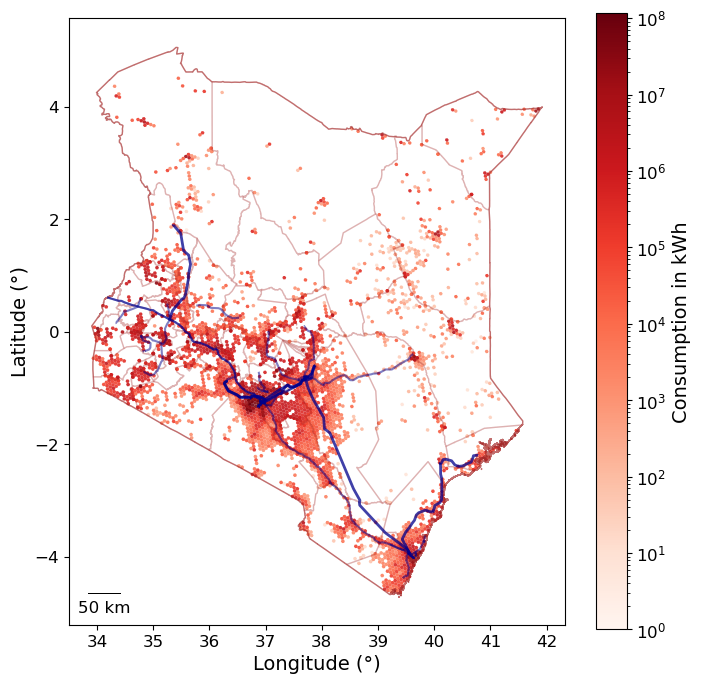

In [45]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(8, 8))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)', fontsize=14)
ax.set_ylabel('Latitude (°)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Plot data
grid.sort_values('REnS_kWh', ascending=True).plot(
    ax=ax, column='REnS_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['REnS_kWh'].max())) #, "orientation": "horizontal"})

#legend
legend = fig.axes[1] 
legend.tick_params(labelsize=12)
legend.set_ylabel("Consumption in kWh", fontsize=14)  # Add a label to the colorbar

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)

# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None,
    font_properties={"size": 12}
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'map_residential_log.png', bbox_inches='tight')

### Services map

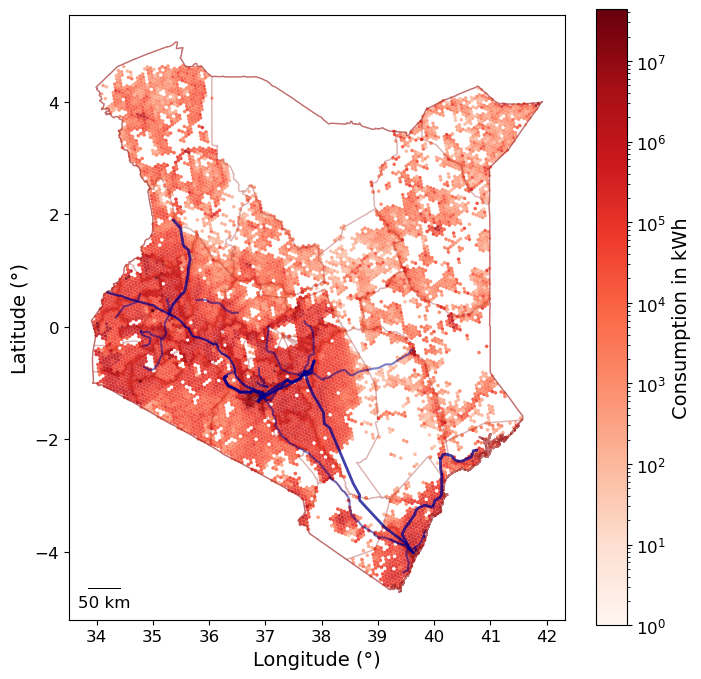

In [47]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(8, 8))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)', fontsize=14)
ax.set_ylabel('Latitude (°)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)


# Plot data
grid.sort_values('SEn_kWh', ascending=True).plot(
    ax=ax, column='SEn_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['SEn_kWh'].max()))

#legend
legend = fig.axes[1] 
legend.tick_params(labelsize=12)
legend.set_ylabel("Consumption in kWh", fontsize=14)  # Add a label to the colorbar

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None,
    font_properties={"size": 12})

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in the services sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in the services sector (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_services_log.png', bbox_inches='tight')

### Buildings map

In [33]:
grid['Bui_GWh'] = grid['SEn_GWh']+grid['REnS_GWh']
grid['Bui_kWh'] = grid['SEn_kWh']+grid['REnS_kWh']

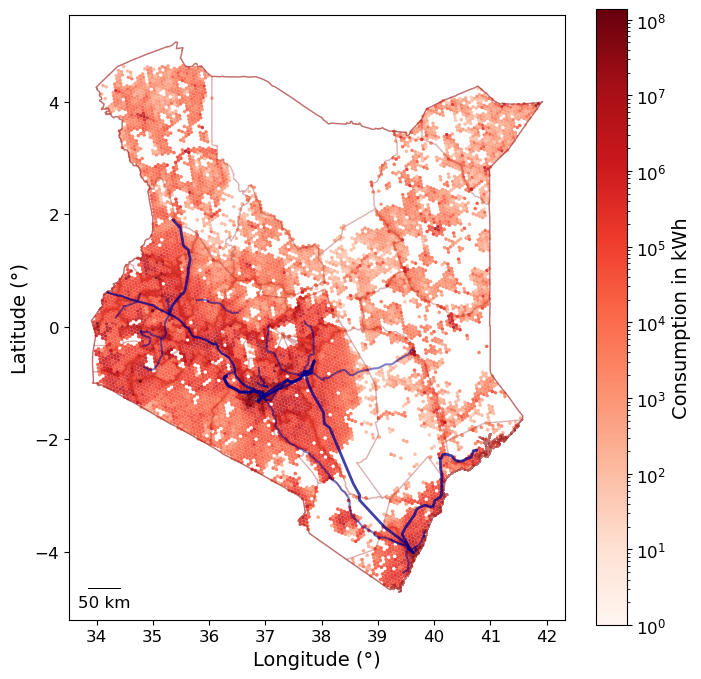

In [48]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)', fontsize=14)
ax.set_ylabel('Latitude (°)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)


# Plot data
grid.sort_values('Bui_kWh', ascending=True).plot(
    ax=ax, column='Bui_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Bui_kWh'].max()))

#legend
legend = fig.axes[1] 
legend.tick_params(labelsize=12)
legend.set_ylabel("Consumption in kWh", fontsize=14)  # Add a label to the colorbar

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None,
    font_properties={"size": 12}
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in buildings in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in buildings (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_buildings_log.png', bbox_inches='tight')

### Industry map

In [35]:
# # Plot the industry demand map per cell
# # Create the axis first
# fig, ax = plt.subplots(figsize=(25, 15))

# # Plot data with a log scale value
# grid.sort_values('IndEnergy_kWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['IndEnergy_kWh'].max()),
#     legend_kwds={"label": "Consumption in kWh"})

# # # Plot data
# # grid.sort_values('IndEnergy_GWh', ascending=True).plot(
# #     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # # Plot data
# # grid.sort_values('IndEnergy_GWh', ascending=True).plot(
# #     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9)

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
# region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# # lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

# # Compute the distance-per-pixel of the map
# # see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# # assert grid.crs == 'EPSG:4326'
# from shapely.geometry.point import Point
# points = gpd.GeoSeries(
#     [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
# )  # Geographic WGS 84 - degrees
# points = points.to_crs(32619)  # Projected WGS 84 - meters
# distance_meters = points[0].distance(points[1])

# # Add a scale bar
# scalebar = ScaleBar(
#     distance_meters,
#     dimension="si-length",
#     location='lower left',
#     length_fraction=0.1,
#     width_fraction=0.001,
#     units='m',
#     color='black',
#     fixed_value=None
# )

# ax.set_aspect('equal', 'box')
# # txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )
# ax.add_artist(scalebar)
# # Save plot as figure 
# plt.savefig(out_path +'map_industry_log.png', bbox_inches='tight')

In [36]:
#(grid['IndEnergy_GWh'] != 0).sum()

In [37]:
#(grid['IndEnergy_GWh'] > 50).sum()

In [38]:
# totalperregion=grid.groupby('NAME_1')['IndEnergy_GWh'].sum()
# totalperregion

In [39]:
#grid['totalindeperregion'] = grid['NAME_1'].map(totalperregion)

In [40]:
# # Plot the demand map with a log scale value
# # Create the axis first
# fig, ax = plt.subplots(figsize=(25, 15))

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['totalindeperregion'].max()))

# # # Plot data
# # grid.sort_values('totalindeperregion', ascending=True).plot(
# #     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # # Plot data
# # grid.sort_values('totalindeperregion', ascending=True).plot(
# #     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
# admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
# ax.set_aspect('equal', 'box')
# ax.set_title('Electricity in the mining sector in Zambia (GWh)')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# from matplotlib.ticker import FuncFormatter

# # fmt = lambda x, pos: '{:.1%}'.format(x)
# # cbar = plt.colorbar(format=FuncFormatter(fmt))

# # Save plot as figure 
# plt.savefig(out_path +'map_log_ind.png', bbox_inches='tight')